In [92]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import ellipk, ellipe
from scipy.stats import linregress
%matplotlib inline


from mpl_settings_v3 import *
#from mpl_settings_v3 import markers

#sns.set()
#sns.set_context('paper')

data_dir = '../../data'
figs_dir = '../../figs'

### **Valores teóricos**

In [124]:
## Temperatura crítica
Tc_theo = 2/np.log(1+np.sqrt(2))
print(Tc_theo)

alpha_theo = 0
beta_theo = 0.125
gamma_theo = 1.75
delta_theo = 15
nu_theo = 1
Delta_theo = beta_theo*delta_theo

## Magnetización
def m_theo_left(t_values, J=1):
    return (1 - np.sinh(2*J/t_values)**(-4))**(1/8)

def m_theo(t_values, J=1):
    n = len(t_values)
    m_values = np.zeros(n)
    for i, t in enumerate(t_values):
        if t < Tc_theo:
            m_values[i] = m_theo_left(t, J)
    return m_values

## Susceptibilidad
def e_theo(t_values, J=1):
    kappa_prima = 2*np.tanh(2*J/t_values)**2 - 1
    kappa_squared = 1-kappa_prima**2
    return -J/np.tanh(2*J/t_values) * (1 + 2/np.pi * kappa_prima*ellipk(kappa_squared))
## Calor específico

def Cp_theo(t_values, J=1):
    kappa_prima = 2*np.tanh(2*J/t_values)**2 - 1
    kappa_squared = 1 - kappa_prima**2
    return 2/np.pi * (J/(t_values*np.tanh(2*J/t_values)))**2 * \
          (2*ellipk(kappa_squared) - 2*ellipe(kappa_squared) - \
           (1-kappa_prima) * (np.pi/2 + kappa_prima*ellipk(kappa_squared)))

2.269185314213022


In [125]:
def load_data(L_values, params):
    
    transit   = params['transit']
    decorr    = params['decorr']
    n_samples = params['n_samples']
    Ti        = params['Ti']
    Tf        = params['Tf']
    delta_T   = params['delta_T']
    
    columns = ['t', 'e', 'm', 'Cp', 'chi', 'm2', 'm4']
    
    dfs = {}
    for L in L_values:
        print(L)
        input_file_name = "L{}_Ti{}_Tf{}_dT{}_transit{}_Ns{}_nsamples{}.dat".format(
            L, Ti, Tf, delta_T, transit,decorr, n_samples
        )
            
        full_input_file_name = os.path.join(data_dir, input_file_name)
        data = np.loadtxt(full_input_file_name)
        df = pd.DataFrame(data, columns=columns)
        dfs[L] = df
    
    return dfs

def load_data_field(L_values, params):
    
    transit   = params['transit']
    decorr    = params['decorr']
    n_samples = params['n_samples']
    T         = params['T']
    Bi        = params['Bi']
    dB        = params['delta_B']
    
    columns = ['B', 'e', 'm', 'Cp', 'chi', 'm2', 'm4']
    
    dfs = {}
    for L in L_values:
        input_file_name = "L{}_T{}_Bi{}_dB{}_transit{}_Ns{}_nsamples{}.dat".format(
        L, T, Bi, dB, transit, decorr, n_samples
    )
            
        full_input_file_name = os.path.join(data_dir, input_file_name)
        data = np.loadtxt(full_input_file_name)
        df = pd.DataFrame(data, columns=columns)
        dfs[L] = df
    
    return dfs

def powerlaw(X, a, c):
    return c*np.array(X)**a

def getLinearReg(sizes, values, mode='logXY', return_intercept=False):
    
    if mode == 'logXY':
        X = np.log(sizes)
        Y = np.log(values)
    elif mode == 'logX':
        X = np.log(sizes)
        Y = np.array(values)
    elif mode == 'logY':
        X = np.array(sizes)
        Y = np.log(values)
    else:
        X = np.array(sizes)
        Y = np.array(values)

    #coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    #errors = np.sqrt(np.diag(cov))
    #r2 = linear_regressor.score(X, Y)
    
    
    #intercept = coeffs[1]
    #slope = coeffs[0]
    #slope_err = errors[0]
    
    
    slope, intercept, r_value, p_value, slope_err = linregress(X, Y)
    r2 = r_value**2
    Y_pred = intercept + X*slope
    
    if mode in ['logY', 'logXY']:
        Y_pred = np.exp(Y_pred)
    if return_intercept:
        return Y_pred, slope, slope_err, r2, intercept
    else:
        return Y_pred, slope, slope_err, r2

In [126]:
params = {
    'transit'   : 10000,
    'decorr'    : 10000,
    'n_samples' : 10000,
    'Ti'        : 1.80,
    'Tf'        : 3.00,
    'delta_T'   : 0.01
}

params = {
    'transit'   : 200000,
    'decorr'    : 200000,
    'n_samples' : 200000,
    'Ti'        : 1.80,
    'Tf'        : 3.00,
    'delta_T'   : 0.01
}

params = {
    'transit'   : 1000000,
    'decorr'    : 1000000,
    'n_samples' : 1000000,
    'Ti'        : '1.9092',
    'Tf'        : '2.8092',
    'delta_T'   : '0.0025'
}

Ti = float(params['Ti'])
Tf = float(params['Tf'])
dT = float(params['delta_T'])

L_values = [16, 32, 64, 128, 200]

dfs = load_data(L_values, params)

theo_t_values = np.linspace(1, Tf, 10000)

16
32
64
128
200


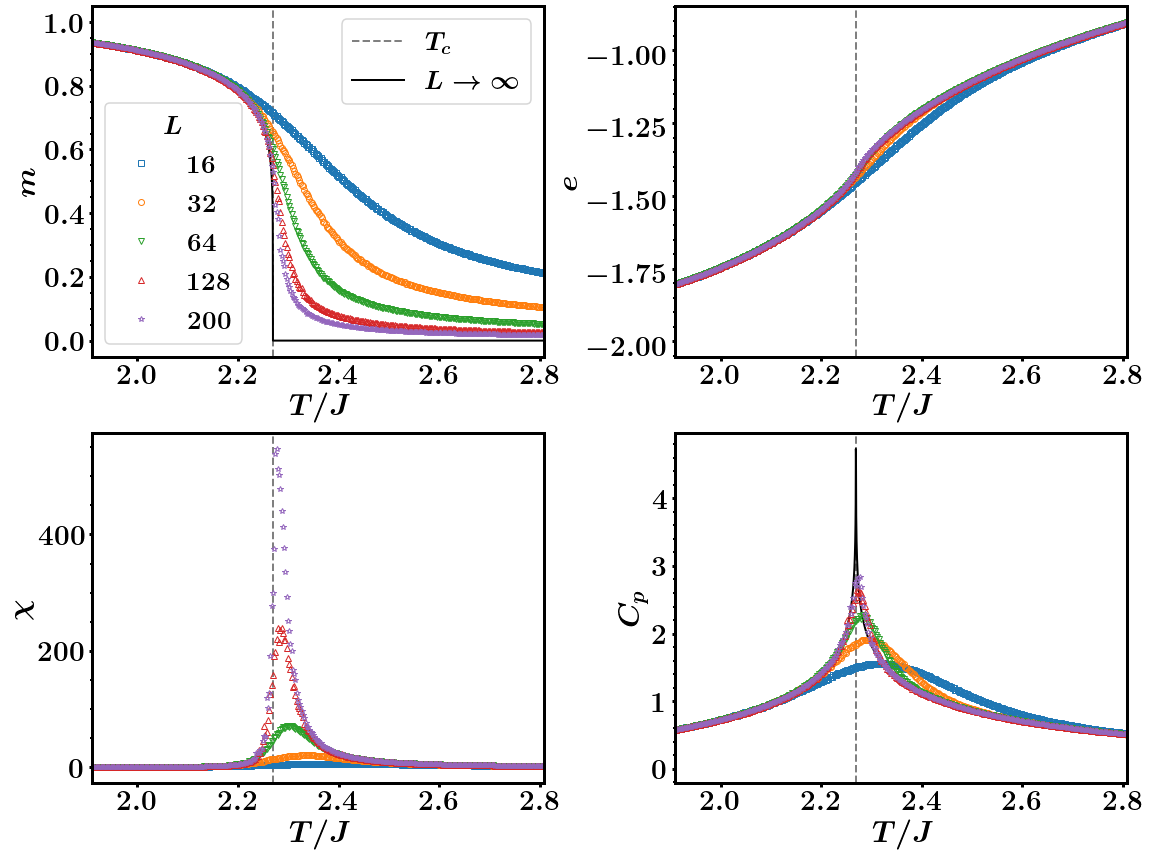

In [127]:
fillstyle = 'none'

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xlabel(r'$T/J$')
    p_tc_theo = ax.axvline(Tc_theo, color='grey', linestyle='--', linewidth=2)
    ax.set_xlim(Ti, Tf)
## Magnetizacion
ax = axes[0][0]
ax.set_ylabel(r'$m$')
p_theo, = ax.plot(theo_t_values, m_theo(theo_t_values), color='k', linewidth=2)

plots = []
for i, L in enumerate(L_values):
    df = dfs[L] 
    plot, = ax.plot(df.t, df.m, markers[i], fillstyle=fillstyle)
    plots.append(plot)
    
legend2 = ax.legend([p_tc_theo, p_theo], [r'$T_c$', r'$L\rightarrow \infty$'], loc='upper right')
ax.add_artist(legend2)
legend1 = ax.legend(plots, ['${{{}}}$'.format(L) for L in L_values], loc='lower left')
legend1.set_title(r'$L$', prop={'size': 26})

## Energia
ax = axes[0][1]
ax.set_ylabel(r'$e$')
ax.plot(theo_t_values, e_theo(theo_t_values), color='k', linewidth=2)
for i, L in enumerate(L_values):
    df = dfs[L]
    ax.plot(df.t, df.e, markers[i], fillstyle=fillstyle)

# Susceptibilidad
ax = axes[1][0]
ax.set_ylabel(r'$\chi$')
for i, L in enumerate(L_values):
    df = dfs[L]
    ax.plot(df.t, df.chi, markers[i], fillstyle=fillstyle)

    
## Calor especifico
ax = axes[1][1]
ax.set_ylabel(r'$C_p$')

ax.plot(theo_t_values, Cp_theo(theo_t_values), color='k', linewidth=2)

for i, L in enumerate(L_values):
    df = dfs[L]
    
    if df.Cp.min() < 0:
        print(L, df.Cp.min())
        continue
    
    ax.plot(df.t, df.Cp,  markers[i], fillstyle=fillstyle)
    
plt.tight_layout()
plt.savefig(figs_dir + '/Fig1.pdf')
plt.show()

### **Comportamiento de la magnetización para $T>T_c$ y tamaños finitos**

En sistemas de tamaño finito, la magnetización no se anula en la fase paramagnética, sino que decae como $\sqrt{N}$. Luego, si graficamos $\sqrt{N}\;m(T, L)$ en función de $T$ para $T > T_c$, las curvas para diferentes tamaños deberían colapsar.

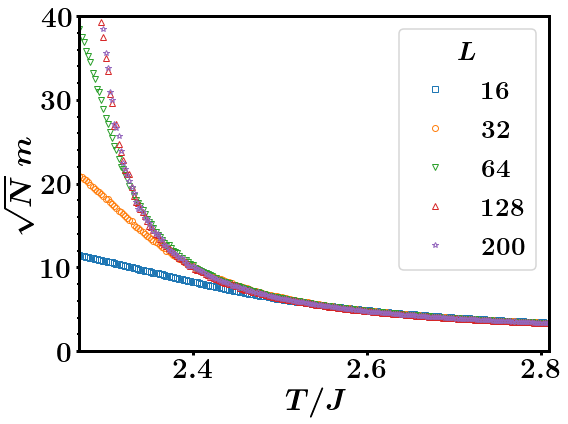

In [128]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax.set_xlabel(r'$T/J$')
ax.set_ylim(0, 40)
ax.axvline(Tc_theo, color='k', linestyle='--', linewidth=2)
    
## Magnetizacion
ax.set_xlim(Tc_theo, Tf)
ax.set_ylabel(r'$\sqrt{N}\;m$')
for i, L in enumerate(L_values):
    df = dfs[L] 
    ax.plot(df.t, df.m*L, markers[i], label=r'${{{}}}$'.format(L), fillstyle=fillstyle)
legend = ax.legend(loc='best')
legend.set_title(r'$L$', prop={'size': 26})
    
plt.tight_layout()
plt.savefig(figs_dir + '/Fig2.pdf')
plt.show()

### **Determinación de $T_c$ utilizando el punto de inflexión en la magnetización**

Estimamos la temperatura crítica extrapolando linealmente el punto de inflexión de la magnetización a tamaño infinito. Para eso, calculamos el punto de inflexión como el máximo en la derivada de $m$ con respecto a $T$.

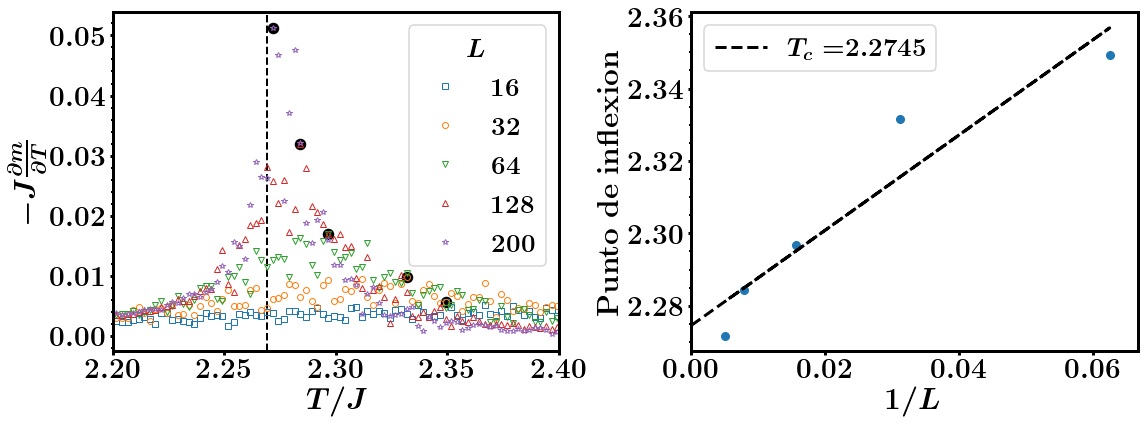

In [129]:
_L_values = L_values
one_over_L = 1/np.array(_L_values)

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xlabel(r'$T/J$')
#ax.set_xlim(1.9, 2.8)
ax.set_xlim(2.2, 2.4)
ax.axvline(Tc_theo, color='k', linestyle='--', linewidth=2)
    
Tc_N_values = []

ax.set_ylabel(r'$-J\frac{\partial m}{\partial T}$')
for i, L in enumerate(_L_values):
    df = dfs[L] 
    Y = -np.gradient(df.m)
    Tc_N = Ti + dT*np.argmax(Y)
    Tc_N_values.append(Tc_N)
    ax.plot(df.t, Y, markers[i], label=r'${{{}}}$'.format(L), fillstyle=fillstyle)
    ax.scatter(Tc_N, np.max(Y), color='k', s=100)
legend = ax.legend(loc='best')
legend.set_title(r'$L$', prop={'size': 26})


ax = axes[1]
ax.set_xlim(0, 1/(_L_values[0]-1))
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$1/L$')
ax.set_ylabel(r'$\mathrm{Punto\;de\;inflexion}$')

ax.plot(one_over_L, Tc_N_values, 'o', markersize=8)

Y_pred, slope, y_err, r2, intercept = getLinearReg(one_over_L, Tc_N_values, mode='linear', return_intercept=True)
line_X = np.zeros(len(_L_values)+1)
line_X[1:] = one_over_L
line_Y = np.zeros(len(_L_values)+1)
line_Y[0] = intercept
line_Y[1:] = Y_pred
ax.plot(line_X, line_Y, '--', color='k', label=r'$T_c =$' + r'${{{:.4f}}}$'.format(intercept))
ax.legend()
    
plt.tight_layout()
plt.savefig(figs_dir + '/Fig3.pdf')
plt.show()

### **Determinación de $T_c$ utilizando cumulantes de Binder**

El cumulante de Binder se define como la curtosis de la distribución de probabilidad de $M$. Es decir,

$$
U = 1 - \dfrac{\langle M \rangle^4}{3\langle M^2 \rangle^2}
$$

A temperatura cero, $U = 2/3$, mientras que a temperatura infinita, $U\rightarrow 0$.

Cerca del punto crítico, el cumulante tiene un comportamiento del tipo 

$$
U(T,L) = b(tL^{1/\nu}),
$$

donde $t = (T-T_c)/T_c$ es la temperatura reducida. Por lo tanto, las curvas de $U(T, L)$ para distintos valores de $L$ deben cruzarse en $T=T_c$.

In [130]:
def Tc_binder(dfs, L_values, params, Tmin=None, Tmax=None):
    
    Ti = float(params['Ti'])
    dT = float(params['delta_T'])
    
    n_sizes = len(L_values)
    
    diffs = np.zeros(len(dfs[L_values[0]].t))
    for i in range(n_sizes):
        df1 = dfs[L_values[i]] 
        U_L1 = 1 - df1.m4 / (3*df1.m2**2)
        for j in range(i, n_sizes):
            df2 = dfs[L_values[j]] 
            U_L2 = 1 - df2.m4 / (3*df2.m2**2)
            
            diffs = diffs + np.fabs(U_L2 - U_L1)
    
    if Tmin:
        mask_min = int((Tmin - Ti)/dT)
        mask_max = int((Tmax - Ti)/dT)
        mask_diffs = diffs[mask_min:mask_max]
        
    Tc = Ti + dT*mask_diffs.idxmin()
    
    return Tc, dT

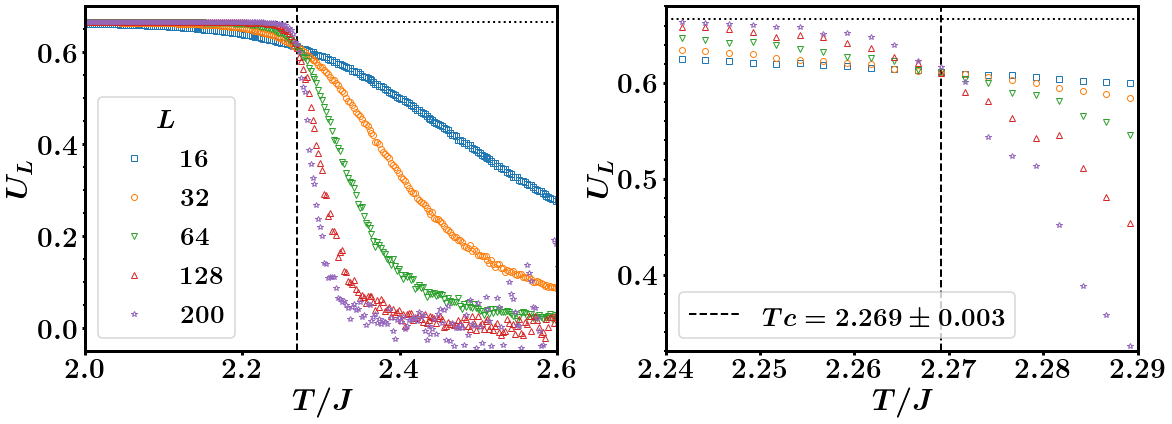

In [131]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xlabel(r'$T/J$')
ax.set_ylim(-0.05, 0.7)
ax.set_xlim(2., 2.6)
ax.axvline(Tc_theo, color='k', linestyle='--', linewidth=2)
ax.axhline(2/3, color='k', linestyle=':', linewidth=2)
    
## Binder
ax.set_ylabel(r'$U_L$')
for i, L in enumerate(L_values):
    df = dfs[L] 
    binder = 1 - df.m4 / (3*df.m2**2)
    ax.plot(df.t, binder, markers[i], label=r'${{{}}}$'.format(L), fillstyle=fillstyle)
legend = ax.legend(loc='lower left')
legend.set_title(r'$L$', prop={'size': 26})

Tc, Tc_err = Tc_binder(dfs, L_values, params, Tmin=2.22, Tmax=2.3)

## Zoom
ax = axes[1]
ax.set_xlabel(r'$T/J$')
ax.set_ylabel(r'$U_L$')
ax.set_xlim(2.24, 2.29)
ax.set_ylim(0.32, 0.68)
ax.axvline(Tc, color='k', linestyle='--', linewidth=2, label=r'$Tc = {{{:.3f}}}\pm{{{:.3f}}}$'.format(Tc, Tc_err))
ax.axhline(2/3, color='k', linestyle=':', linewidth=2)

for i, L in enumerate(L_values):
    df = dfs[L] 
    binder = 1 - df.m4 / (3*df.m2**2)
    binder_smooth = (binder[:-1] + binder[1:])/2
    time = df.t[1:]
    ax.plot(df.t, binder_smooth, markers[i], fillstyle=fillstyle)
ax.legend()

plt.tight_layout()
plt.savefig(figs_dir + '/Fig4.pdf')
plt.show()

Colapso de las curvas de cumulantes de binder

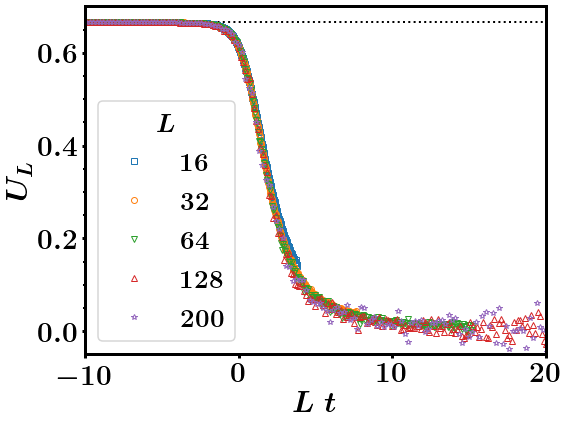

In [132]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax.set_xlabel(r'$L\;t$')
ax.set_xlim(-10, 20)
ax.axhline(2/3, color='k', linestyle=':', linewidth=2)
ax.set_ylim(-0.05, 0.7)
    
## Binder
ax.set_ylabel(r'$U_L$')
for i, L in enumerate(L_values):
    df = dfs[L] 
    binder = 1 - df.m4 / (3*df.m2**2)
    ax.plot(L*(df.t-Tc_theo)/Tc_theo, binder, markers[i], label=r'${{{}}}$'.format(L), fillstyle=fillstyle)
legend = ax.legend(loc='lower left')
legend.set_title(r'$L$', prop={'size': 26})

plt.tight_layout()
plt.savefig(figs_dir + '/Fig5.pdf')
plt.show()

### **Divergencia de la susceptibilidad en el punto crítico.**

Estimamos el cociente entre exponentes críticos $\gamma/\nu$ ajustando los máximos de $\chi$

In [133]:
max_chi_values = np.zeros(len(L_values))
for i, L in enumerate(L_values):
    df = dfs[L]
    
    max_chi = np.max(df.chi)
    max_chi_values[i] = max_chi

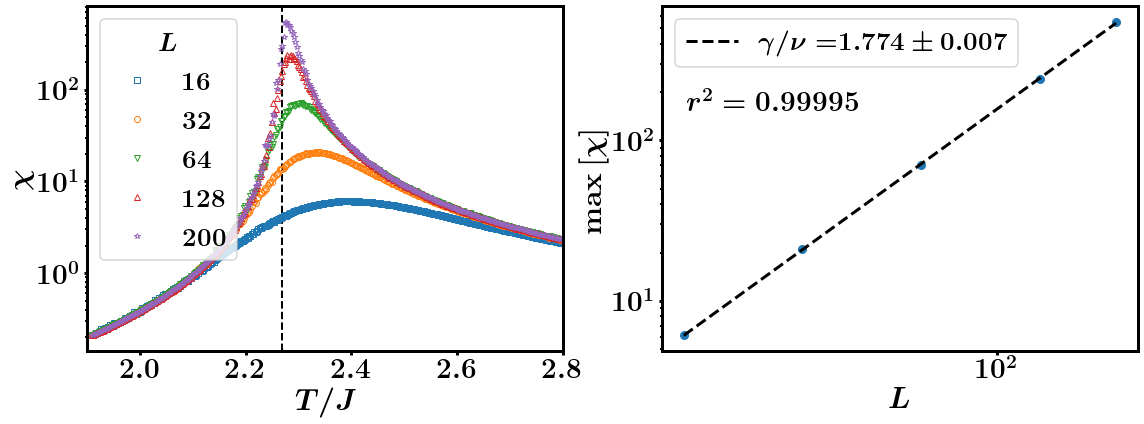

In [134]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_ylabel(r'$\chi$')
ax.set_xlabel(r'$T/J$')
ax.set_yscale('log')
ax.set_xlim(1.9, 2.8)
ax.axvline(Tc_theo, color='k', linestyle='--', linewidth=2)
for i, L in enumerate(L_values):
    df = dfs[L]
    ax.plot(df.t, df.chi, markers[i], fillstyle=fillstyle, label=r'${{{}}}$'.format(L))
legend = ax.legend()
legend.set_title(r'$L$', prop={'size': 26})    

ax = axes[1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{max}\left[ \chi\right]$')
ax.plot(L_values, max_chi_values, 'o', markersize=8)

Y_pred, slope, y_err, r2 = getLinearReg(L_values, max_chi_values)
ax.text(0.05, 0.7, r'$r^2 = {{{:.5f}}}$'.format(r2), fontsize=28, transform=ax.transAxes)
ax.plot(L_values, Y_pred, '--', color='k', 
        label=r'$\gamma/\nu =$' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err))
ax.legend()

plt.tight_layout()
plt.savefig(figs_dir + '/Fig6.pdf')
plt.show()

### **Estimación del exponente $\nu$ y de $T_c$ utilizando el desplazamiento de los máximos en la susceptibilidad**

Utilizamos la expresión 

$$
T^*(L) = T_c + A L^{1/{\nu}}
$$

para estimar $\nu$. En el primer caso, estimamos simultaneamente $T_c$, eligiendo el valor que maximice el $r^2$ del ajuste. En el segundo caso, utilizamos el valor teórico de $T_c$

In [135]:
Tc_L_values = np.zeros(len(L_values))
for i, L in enumerate(L_values):
    df = dfs[L]
    argmax_chi = Ti + dT*df.chi.idxmax()
    Tc_L_values[i] = argmax_chi

2.258058058058058 0.9972681099819524


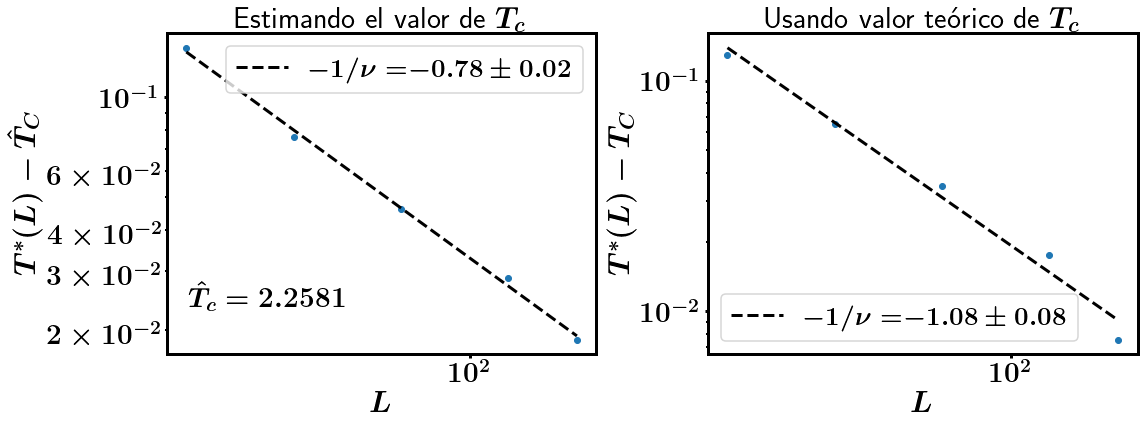

In [136]:
Tc_values = np.linspace(2.2, 2.3, 1000)
max_r2 = 0
for _Tc in Tc_values:
    
    if _Tc >= Tc_L_values.min():
        continue
    
    _Y_pred, _slope, _y_err, r2 = getLinearReg(L_values, Tc_L_values-_Tc)
    if r2 > max_r2:
        Tc = _Tc
        max_r2 = r2
        Y_pred = _Y_pred
        slope = _slope
        y_err = _y_err
        
print(Tc, max_r2)

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$L$') 

    
ax = axes[0]
ax.set_title('Estimando el valor de ' + r'$T_c$', fontsize=30)
ax.set_ylabel(r'$T^*(L) - \hat{T}_C$')
ax.plot(L_values, Tc_L_values-Tc, 'o', color=colors[0])
ax.text(0.05, 0.15, r'$\hat{T}_c\;$' + r'$ = {{{:.4f}}}$'.format(Tc), fontsize=28, transform=ax.transAxes)
    
ax.plot(L_values, Y_pred, '--', color='k', 
        label=r'$-1/\nu =$' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))
ax.legend()


ax = axes[1]
ax.set_title('Usando valor teórico de ' + r'$T_c$', fontsize=30) 
ax.set_ylabel(r'$T^*(L) - T_C$')
ax.plot(L_values, Tc_L_values-Tc_theo, 'o', color=colors[0])
    
Y_pred, slope, y_err, r2 = getLinearReg(L_values, Tc_L_values-Tc_theo)
ax.plot(L_values, Y_pred, '--', color='k', 
        label=r'$-1/\nu =$' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))
ax.legend()
    
plt.tight_layout()
plt.savefig(figs_dir + '/Fig7.pdf')
plt.show()

### **Estimación de $\beta/\nu$**



Utilizamos la relacion de escala

$$
m(T, L) \sim L^{-\beta/\nu} \tilde{m}(t L^{1/\nu}).
$$

En el punto critico, tenemos que

$$
 m(T_c, L) \sim L^{-\beta/\nu} \tilde{m}(0).
$$

Luego, si graficamos $ m(T_c, L)$ vs $L$ veremos una recta en escala log-log. Ajustando la pendiente de la recta obtenemos el cociente $\beta/\nu$.

In [137]:
m_Tc_values = np.zeros(len(L_values))
Tc_idx = np.ceil((Tc_theo - Ti)/dT)

for i, L in enumerate(L_values):
    df = dfs[L]
    m_Tc = df.m[Tc_idx]
    m_Tc_values[i] = m_Tc

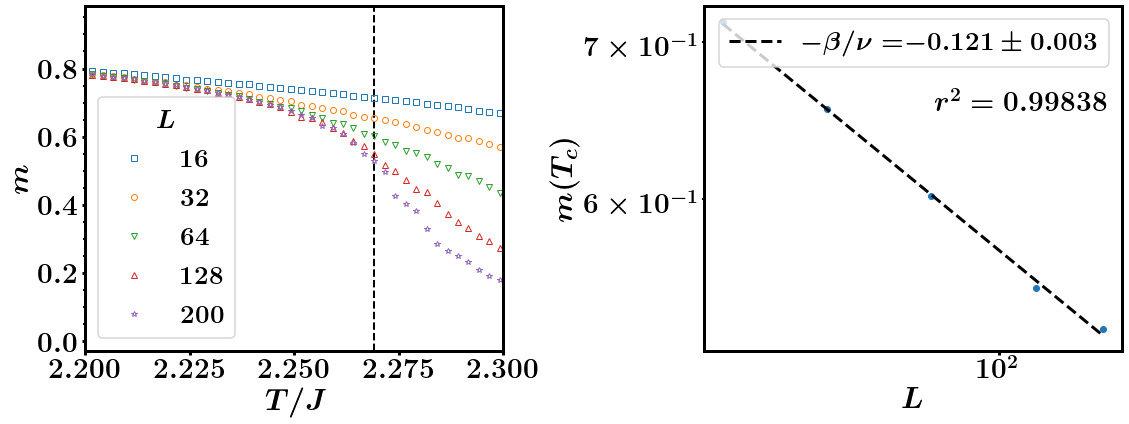

In [138]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_ylabel(r'$m$')
ax.set_xlabel(r'$T/J$')
ax.set_xlim(2.2, 2.3)
ax.axvline(Tc_theo, color='k', linestyle='--', linewidth=2)
for i, L in enumerate(L_values):
    df = dfs[L]
    ax.plot(df.t, df.m, markers[i], fillstyle='none', label=r'${{{}}}$'.format(L))
legend = ax.legend()
legend.set_title(r'$L$', prop={'size': 26})

ax = axes[1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$m(T_c)$')
ax.plot(L_values, m_Tc_values, 'o')

Y_pred, slope, y_err, r2 = getLinearReg(L_values, m_Tc_values)
ax.text(0.55, 0.7, r'$r^2 = {{{:.5f}}}$'.format(r2), fontsize=28, transform=ax.transAxes)
ax.plot(L_values, Y_pred, '--', color='k', 
        label=r'$-\beta/\nu =$' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err))
ax.legend()

plt.tight_layout()
plt.savefig(figs_dir + '/Fig8.pdf')
plt.show()

### **Divergencia del calor específico en el punto crítico.**

Estimamos el cociente entre exponentes críticos $\alpha$ ajustando los máximos de $C_p$

In [139]:
max_Cp_values = np.zeros(len(L_values))
for i, L in enumerate(L_values):
    df = dfs[L]
    
    max_Cp = np.max(df.Cp)
    max_Cp_values[i] = max_Cp

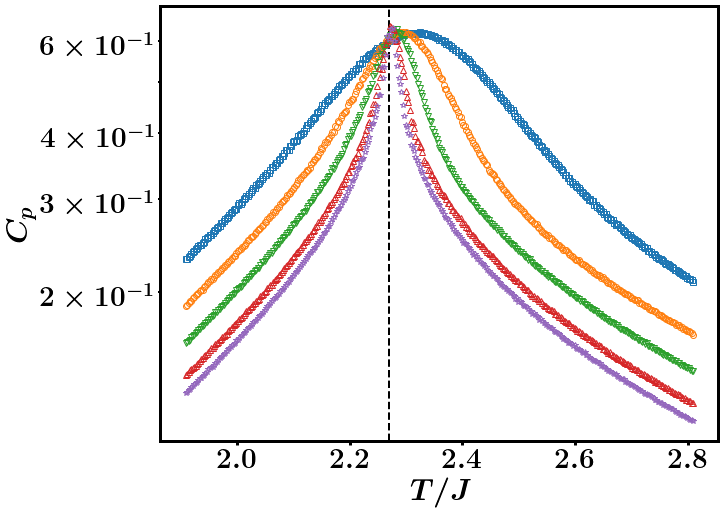

In [178]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_ylabel(r'$C_p$')
ax.set_xlabel(r'$T/J$')
ax.set_yscale('log')
#ax.set_xlim(1.9, 2.8)
ax.axvline(Tc_theo, color='k', linestyle='--', linewidth=2)
for i, L in enumerate(L_values):
    df = dfs[L]
    
    x = df.t
    #y = df.Cp*L**(-0.25)
    y = df.Cp/np.log(L)**(0.9)
    
    ax.plot(x, y, markers[i], fillstyle='none')

plt.show()

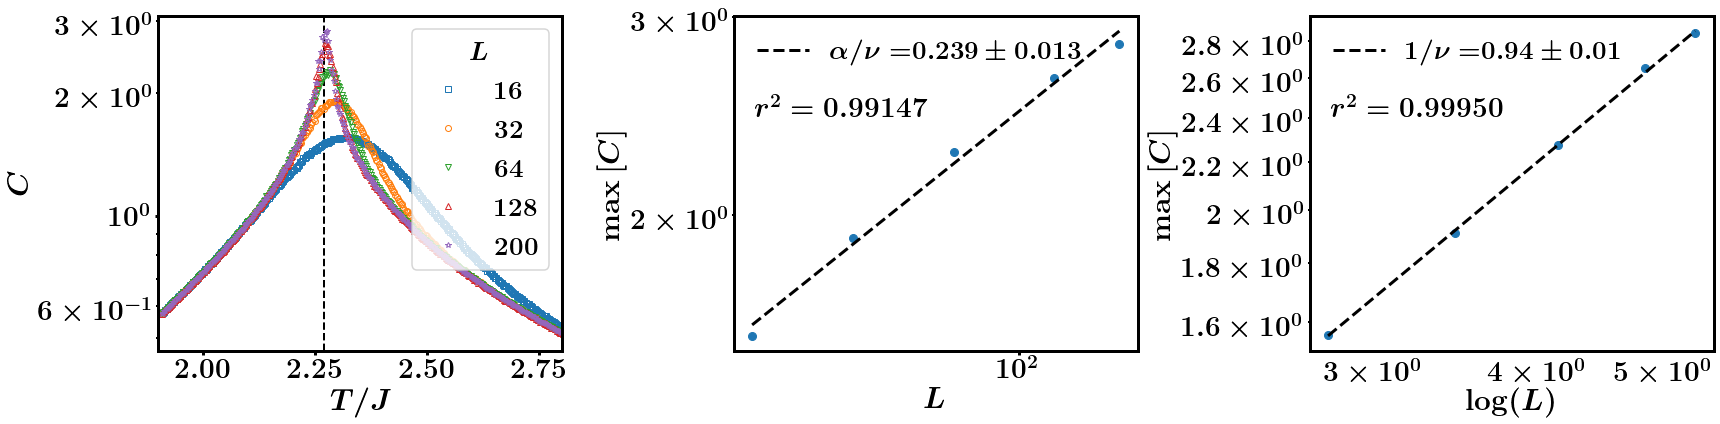

In [187]:
# ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_ylabel(r'$C$')
ax.set_xlabel(r'$T/J$')
ax.set_yscale('log')
ax.set_xlim(1.9, 2.8)
ax.axvline(Tc_theo, color='k', linestyle='--', linewidth=2)
for i, L in enumerate(L_values):
    df = dfs[L]
    ax.plot(df.t, df.Cp, markers[i], fillstyle='none', label=r'${{{}}}$'.format(L))    
legend = ax.legend()
legend.set_title(r'$L$', prop={'size': 26})

ax = axes[1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{max}\left[ C \right]$')

X = np.array(L_values)
#X = np.array(L_values)

ax.plot(X, max_Cp_values, 'o', markersize=8)
Y_pred, slope, y_err, r2 = getLinearReg(X, max_Cp_values)
ax.text(0.05, 0.7, r'$r^2 = {{{:.5f}}}$'.format(r2), fontsize=28, transform=ax.transAxes)
ax.plot(X, Y_pred, '--', color='k', 
        label=r'$\mathrm{\alpha/\nu}=$' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err))
ax.legend(frameon=False)

ax = axes[2]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\log(L)$')
ax.set_ylabel(r'$\mathrm{max}\left[ C \right]$')

X = np.log(L_values)
#X = np.array(L_values)

ax.plot(X, max_Cp_values, 'o', markersize=8)
Y_pred, slope, y_err, r2, intercept = getLinearReg(X, max_Cp_values, mode='logXY', return_intercept=True)
ax.text(0.05, 0.7, r'$r^2 = {{{:.5f}}}$'.format(r2), fontsize=28, transform=ax.transAxes)
#ax.text(0.05, 0.7, r'$\mathrm{Ordenada}=$' + r'${{{:.3f}}}$'.format(intercept), fontsize=28, transform=ax.transAxes)
ax.plot(X, Y_pred, '--', color='k', 
        label=r'$1/\nu=$' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))
ax.legend(frameon=False)

plt.tight_layout()

plt.savefig(figs_dir + '/Fig11.pdf')

plt.show()

### **Colapsos de las curvas**

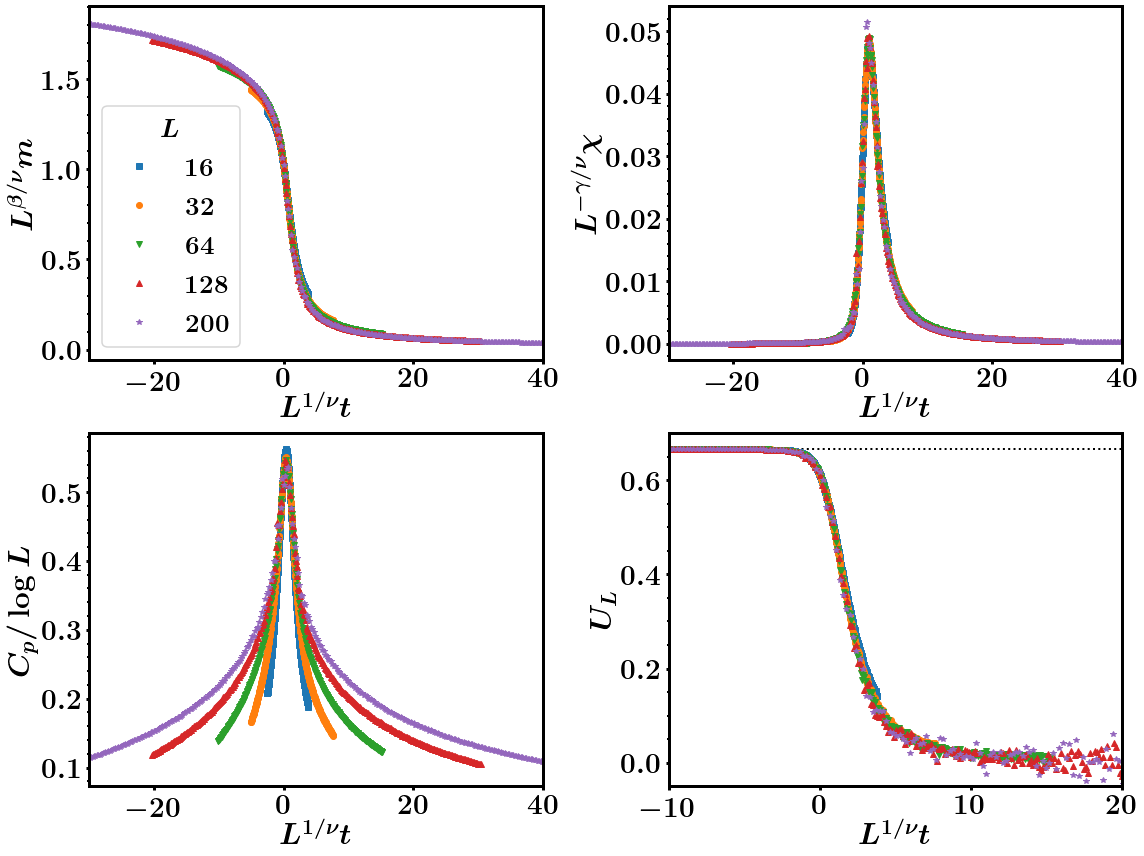

In [116]:
ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xlim(-30, 40)

    
## Parametro de orden
ax = axes[0][0]
ax.set_xlabel(r'$L^{1/\nu}t$')
ax.set_ylabel(r'$L^{\beta/\nu}m$')
for i, L in enumerate(L_values):
    df = dfs[L] 
    ax.plot((L**nu_theo)*(df.t-Tc_theo)/Tc_theo, (L**(beta_theo/nu_theo))*df.m, markers[i], label=r'${{{}}}$'.format(L))
legend = ax.legend(loc='lower left')
legend.set_title(r'$L$', prop={'size': 26})


## Susceptibilidad
ax = axes[0][1]
ax.set_xlabel(r'$L^{1/\nu}t$')
ax.set_ylabel(r'$L^{-\gamma/\nu}\chi$')
for i, L in enumerate(L_values):
    df = dfs[L] 
    ax.plot((L**nu_theo)*(df.t-Tc_theo)/Tc_theo, (L**-(gamma_theo/nu_theo))*df.chi, markers[i])


## Calor específico
ax = axes[1][0]
ax.set_xlabel(r'$L^{1/\nu}t$')
ax.set_ylabel(r'$C_p/\log L$')
for i, L in enumerate(L_values):
    df = dfs[L] 
    ax.plot((L**nu_theo)*(df.t-Tc_theo)/Tc_theo, df.Cp/np.log(L), markers[i])


## Cumulante de Binder
ax = axes[1][1]
ax.set_xlabel(r'$L^{1/\nu}t$')
ax.set_xlim(-10, 20)
ax.axhline(2/3, color='k', linestyle=':', linewidth=2)
ax.set_ylim(-0.05, 0.7)
ax.set_ylabel(r'$U_L$')
for i, L in enumerate(L_values):
    df = dfs[L] 
    binder = 1 - df.m4 / (3*df.m2**2)
    ax.plot((L**nu_theo)*(df.t-Tc_theo)/Tc_theo, binder, markers[i])


plt.tight_layout()
plt.show()

### **Valores teóricos**

$$
\begin{align}
T_C &= 2.2692 \\
\alpha &= 0 \\
\beta &= 1/8 \\
\gamma &= 7/4 \\
\nu &= 1 \\
\delta &= 15
\end{align}
$$

### **Magnetización Vs Campo**

In [189]:
params = {
    'transit'   : 10000,
    'decorr'    : 10000,
    'n_samples' : 10000,
    'Bi'        : '1.00',
    'delta_B'   : 0.01
}

L_values = [16, 32, 64]#, 128]

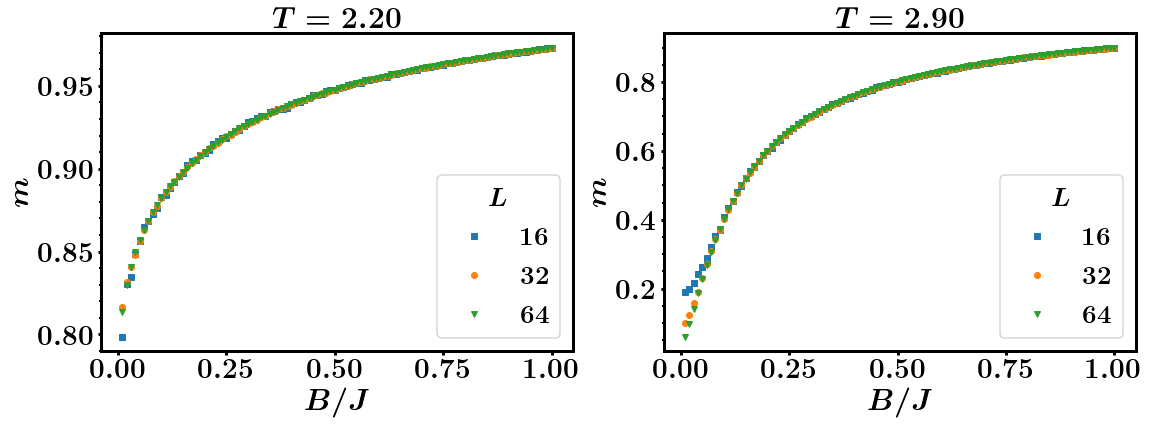

In [118]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xlabel(r'$B/J$')
    ax.set_ylabel(r'$m$')
    
for i, T in enumerate(['2.20', '2.90']):
    
    params['T'] = T
    dfs_f = load_data_field(L_values, params)
    
    ax = axes[i]
    ax.set_title(r'$T = {}$'.format(T), fontsize=30)
    for i, L in enumerate(L_values):
        df = dfs_f[L] 
        ax.plot(df.B, df.m, markers[i], fillstyle='none', label=r'${{{}}}$'.format(L))
    legend = ax.legend(loc='best')
    legend.set_title(r'$L$', prop={'size': 26})
    
plt.tight_layout()
plt.savefig(figs_dir + '/Fig9.pdf')
plt.show()

In [213]:
params = {
    'transit'   : 10000,
    'decorr'    : 10000,
    'n_samples' : 10000,
    'Bi'        : '0.100',
    'delta_B'   : 0.001
}

L_values = [64]

15.175416897523393


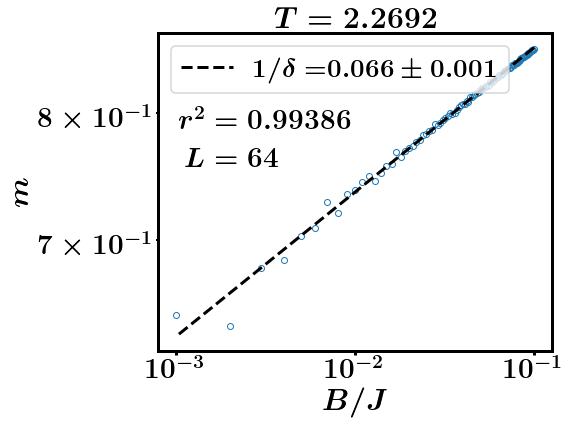

In [214]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax.set_xlabel(r'$B/J$')
ax.set_ylabel(r'$m$')
ax.set_xscale('log')
ax.set_yscale('log')
    
T = '2.2692'
params['T'] = T
dfs_f = load_data_field(L_values, params)
L = L_values[-1]
df = dfs_f[L] 
ax.set_title(r'$T = {}$'.format(T), fontsize=30)

Bmax = df.B.max()
mask = df.B <= Bmax
X = df.B[mask]
Y = df.m[mask]

ax.plot(X, Y, 'o', fillstyle='none')

Y_pred, slope, y_err, r2 = getLinearReg(X, Y)
print(1/slope)
ax.text(0.05, 0.7, r'$r^2 = {{{:.5f}}}$'.format(r2), fontsize=28, transform=ax.transAxes)
ax.text(0.07, 0.58, r'$L = {{{}}}$'.format(L), fontsize=28, transform=ax.transAxes)
ax.plot(X, Y_pred, '--', color='k', 
        label=r'$1/\delta =$' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err))

legend = ax.legend(loc='upper left')
#legend.set_title(r'$L$', prop={'size': 26})
    
plt.tight_layout()
plt.savefig(figs_dir + '/Fig9.pdf')
plt.show()

In [119]:
params = {
    'transit'   : 10000,
    'decorr'    : 10000,
    'n_samples' : 10000,
    'Bi'        : '1.00',
    'delta_B'   : 0.01
}

Tc_str = '2.2692'
L = 32
T_values = ['2.50', '2.60', Tc_str, '2.80', '2.90']
float_T_values = list(map(float, T_values))

m0_values = []
m_inf_values = []
dfs_T = {}
for T in T_values:
    params['T'] = T
    dfs = load_data_field([L], params)
    dfs_T[T] = dfs[L]
    
    m0 = dfs[L].m.values[-1]
    m0_values.append(m0)    
    
    m_inf = dfs[L].m.values[0]
    m_inf_values.append(m_inf)    
    
m0_values = np.array(m0_values)
m_inf_values = np.array(m_inf_values)

0.10171698377442874
0.14578566312540592
0.2339230218273601
0.2779917011783373


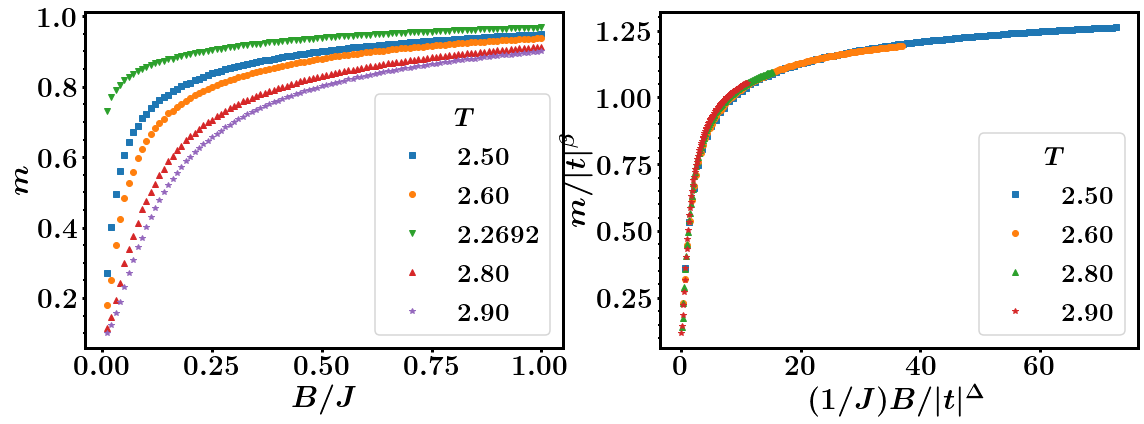

In [120]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xlabel(r'$B/J$')
ax.set_ylabel(r'$m$')
for i, T in enumerate(T_values):
    df = dfs_T[T] 
    ax.plot(df.B, df.m, markers[i], label=r'${{{}}}$'.format(T))
legend = ax.legend(loc='best')
legend.set_title(r'$T$', prop={'size': 26})

ax = axes[1]
ax.set_xlabel(r'$(1/J) B/|t|^{\Delta}$')
ax.set_ylabel(r'$m/|t|^{\beta}$')
for i, T in enumerate(T_values):
    if T == Tc_str:
        continue
    t_theo = np.fabs(float(T)-Tc_theo)/Tc_theo
    print(t_theo)
    df = dfs_T[T] 
    ax.plot(df.B/t_theo**Delta_theo, df.m/t_theo**beta_theo, markers[i], fillstyle='none', label=r'${{{}}}$'.format(T))
    #ax.plot(df.m/t_theo**beta_theo, df.B/t_theo**Delta_theo, markers[i], label=r'${{{}}}$'.format(T))
legend = ax.legend(loc='best')
legend.set_title(r'$T$', prop={'size': 26})
    
plt.tight_layout()
plt.savefig(figs_dir + '/Fig10.pdf')
plt.show()

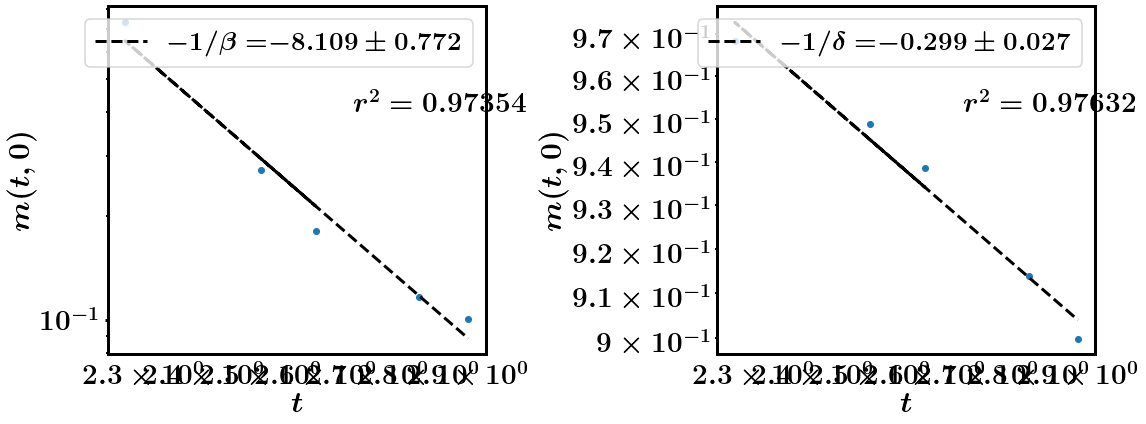

In [121]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$m(t,0)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(float_T_values, m0_values, 'o')

Y_pred, slope, y_err, r2 = getLinearReg(float_T_values, m0_values)
ax.text(0.65, 0.7, r'$r^2 = {{{:.5f}}}$'.format(r2), fontsize=28, transform=ax.transAxes)
ax.plot(float_T_values, Y_pred, '--', color='k', 
        label=r'$-1/\beta =$' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err))
ax.legend()

ax = axes[1]
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$m(t,0)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(float_T_values, m_inf_values, 'o')

Y_pred, slope, y_err, r2 = getLinearReg(float_T_values, m_inf_values)
ax.text(0.65, 0.7, r'$r^2 = {{{:.5f}}}$'.format(r2), fontsize=28, transform=ax.transAxes)
ax.plot(float_T_values, Y_pred, '--', color='k', 
        label=r'$-1/\delta =$' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err))
ax.legend()
    
plt.tight_layout()
plt.show()